
# Анализ данных об оптовых продажах аудиотехники

## Описание проекта

Компания, занимающаяся оптовыми продажами аудиотехники, заинтересована в изучении динамики продаж, 
популярности брендов и эффективности работы менеджеров. Цель проекта — провести всесторонний анализ 
данных, выявить ключевые метрики, а также предложить рекомендации по улучшению бизнес-процессов.

## Основные задачи:

1. Исследовать общую динамику заказов.
2. Определить ключевые метрики: выручка, средний чек, динамика внутри месяца.
3. Выявить популярные и не востребованные бренды.
4. Оценить работу менеджеров.

Проект включает анализ данных, построение визуализаций и вывод практических рекомендаций.


**В проекте предстоит поработать аналитиком данных в компании, которая занимается оптовой продажей аудиотехники и предлагает широкий ассортимент товаров от ведущих мировых брендов, включающий профессиональные аудиосистемы, домашние кинотеатры, портативные аудиоустройства и прочие аксессуары.** 

Компания сотрудничает с крупными розничными сетями и специализированными магазинами аудиотехники в России. Клиенты компании регулярно оставляют заявки на закупку товаров в CRM системе, менеджеры связываются с клиентами, обсуждают детали, после чего заказы либо подтверждаются менеджерами, либо по разным причинам отменяются. 

Необходимо собрать данные из разрозненных источников, проанализировать их и сделать выводы, которые помогут руководству компании принять верные тактические решения.

**В ходе работы над проектом встретятся следующие таблицы:**  

1) orders (данные о заказах):  
- order_id — номер заказа  
- product_id — идентификатор товара  
- quantity — количество этого товара в заказе

2) order_status (данные о статусах заказов и клиентах):
- order_id — номер заказа  
- client_id — идентификатор клиента  
- status — статус заказа

3) products (данные о товарах):
- id — идентификатор товара  
- name — имя товара (сначала указан бренд, через запятую модель товара)  
- price — цена единицы товара, в долларах

Каждый заказ имеет статус или подтвержденного (`confirmed`), или отмененного (`canceled`). В одном заказе может быть несколько разных товаров. Если заказ был отменен, а потом создан такой же (тем же клиентом, с теми же товарами, у того же менеджера), в базе останется запись о двух заказах с разными номерами и статусами, поскольку система не позволяет создать заказ с тем же номером.

Кроме того есть файл `usd_rate.txt` с курсом доллара США на каждый день анализируемого периода (данные в формате `дата,курс,валюта`).

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df_orders = pd.read_csv('/Users/kirilldayneko/Desktop/jupyter/pandas/project/df_orders.csv')
df_products = pd.read_csv('/Users/kirilldayneko/Desktop/jupyter/pandas/project/df_products.csv')
df_order_status = pd.read_csv('/Users/kirilldayneko/Desktop/jupyter/pandas/project/df_order_status.csv')

In [4]:
df_orders.shape

(4603, 5)

In [5]:
df_products.shape

(1677, 4)

In [6]:
df_order_status.shape

(346, 3)

In [7]:
df_orders.dtypes

order_id      object
product_id     int64
quantity       int64
manager       object
date          object
dtype: object

In [9]:
df_orders['date'] = pd.to_datetime(df_orders.date)
df_orders.dtypes

order_id              object
product_id             int64
quantity               int64
manager               object
date          datetime64[ns]
dtype: object

In [10]:
df_products.dtypes

id            int64
name         object
price       float64
category     object
dtype: object

In [12]:
df_order_status.dtypes

order_id     object
client_id     int64
status       object
dtype: object

### Посмотрим на общую динамику заказов и определим дни, которые выбиваются из общей картины

Посчитаем количество заказов в каждый день. **Определим день с наибольшим числом заказов.**

In [14]:
# Считаем количество уникальных заказов по датам
unique_orders = df_orders.groupby('date', as_index=False)\
    .agg({'order_id':'nunique'})\
    .rename(columns={'order_id':'orders'})\
    .sort_values('orders', ascending=False)
unique_orders.head(1)

,date,orders
13,2024-03-14,34


**Построем график с количеством заказов по дням и определите, заметна ли в данных сезонность.**  

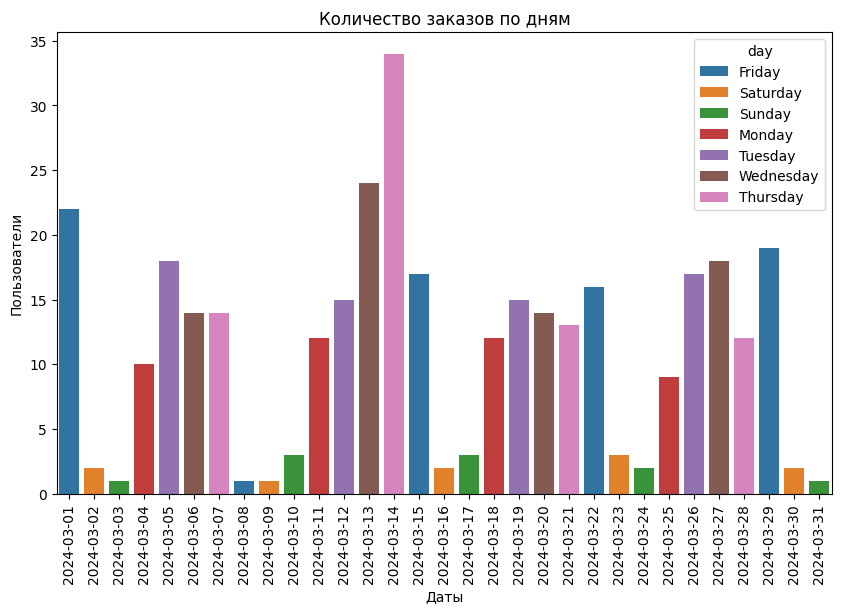

In [37]:
# Строим график для визуализации данных
unique_orders['day'] = unique_orders.date.dt.day_name()
unique_orders = unique_orders.sort_values('date')
plt.figure(figsize=(10, 6))
sns.barplot(data=unique_orders, x='date', y='orders', hue='day')
plt.title('Количество заказов по дням')
plt.xlabel('Даты')
plt.ylabel('Пользователи')
plt.xticks(rotation=90)
plt.show()

На этом графике видно, что в выходные дни мало заказов.Кажется, в данных помимо дня с наибольшим числом заказов есть еще один день, который выбивается из общей картины. Это пятница, обычно в пятницу много заказов, но пятница 8 марта - это праздничный нерабочий день, поэтому в этот день было мало заказов



Почему заказы в один из дней резко подскочили? Возможно, в день с наибольшим числом заказов отдел маркетинга запустил какую-то акцию? Или менеджеры стали активнее предлагать компаниям оформить заказ?

In [16]:
order_status = df_order_status.merge(df_orders, how='inner', on='order_id')
order_status.shape

(4603, 7)

In [17]:
order_status.head()

,order_id,client_id,status,product_id,quantity,manager,date
0,QPLK-54839036,52,confirmed,489,11,Владимир Ударников,2024-03-10
1,QPLK-54839036,52,confirmed,594,6,Владимир Ударников,2024-03-10
2,QPLK-54839036,52,confirmed,670,16,Владимир Ударников,2024-03-10
3,QPLK-54839036,52,confirmed,469,9,Владимир Ударников,2024-03-10
4,QPLK-54839036,52,confirmed,1302,5,Владимир Ударников,2024-03-10


Посмотрим на количество и соотношение подтвержденных и отмененных заказов.

In [18]:
order_status.status.value_counts(normalize=True).round(2)


status
confirmed    0.89
canceled     0.11
Name: proportion, dtype: float64

**Посчитаем количество подтвержденных и отмененных заказов на каждую дату.** Определим, в какой день не было ни одного подтвержденного заказа.

In [21]:
orders_status_pivot = order_status.groupby(['date', 'status'], as_index=False).agg({'order_id':'nunique'})\
    .rename(columns={'order_id':'orders'})\
    .pivot(index='date', columns='status', values='orders').fillna(0)\
    .astype({'canceled':'int', 'confirmed':'int'})
orders_status_pivot

status,canceled,confirmed
date,,
2024-03-01,2,20
2024-03-02,0,2
2024-03-03,0,1
2024-03-04,0,10
2024-03-05,0,18
2024-03-06,1,13
2024-03-07,1,13
2024-03-08,0,1
2024-03-09,1,0


In [22]:
orders_status_pivot.query('confirmed == 0')

status,canceled,confirmed
date,,
2024-03-09,1,0


**Построем график с заказами по дням в разбивке по статусу заказа.** Посмотрим подробнее на день с наибольшим числом заказов.

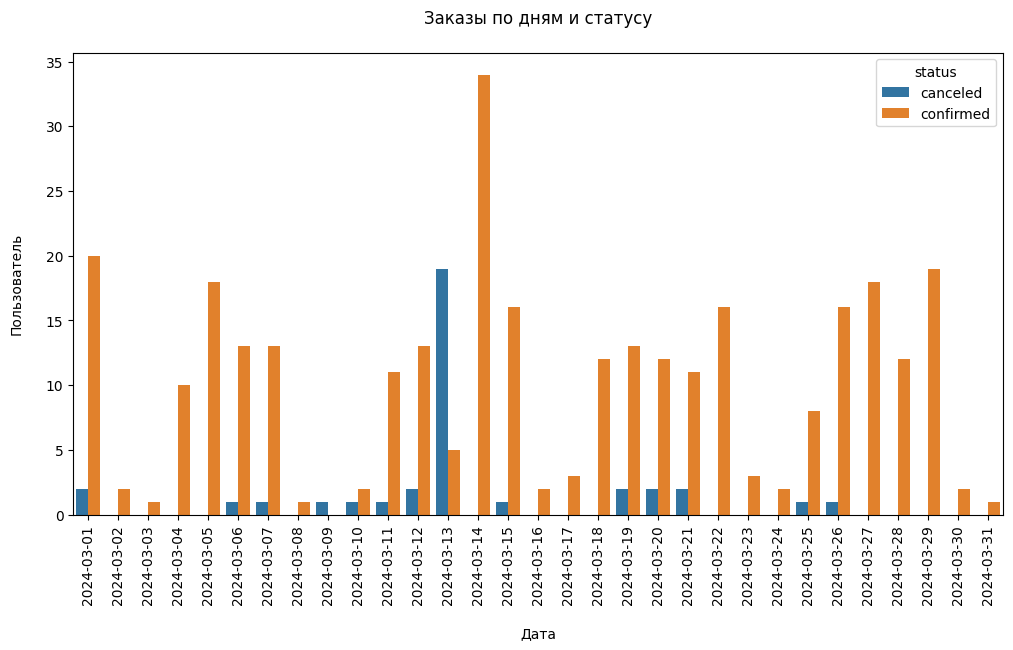

In [20]:
# Строим график для визуализации данных
plt.figure(figsize=(12, 6))
orders_date_status = order_status.groupby(['date', 'status'], as_index=False).agg({'order_id':'nunique'})\
    .rename(columns={'order_id':'orders'})
sns.barplot(data=orders_date_status, x='date', y='orders', hue='status')
plt.xticks(rotation=90)
plt.title('Заказы по дням и статусу\n')
plt.xlabel('\nДата')
plt.ylabel('Пользователь\n')
plt.show()

В день с наибольшим числом заказов было много успешно оформленных заказов

В день, предшествующий дню с наибольшим числом заказов, было много отмен

Рассмотрим эти два дня отдельно день с наибольшим числом заказов, который мы определили ранее, и день, предшествующий ему.

In [23]:
order_status.head()

,order_id,client_id,status,product_id,quantity,manager,date
0,QPLK-54839036,52,confirmed,489,11,Владимир Ударников,2024-03-10
1,QPLK-54839036,52,confirmed,594,6,Владимир Ударников,2024-03-10
2,QPLK-54839036,52,confirmed,670,16,Владимир Ударников,2024-03-10
3,QPLK-54839036,52,confirmed,469,9,Владимир Ударников,2024-03-10
4,QPLK-54839036,52,confirmed,1302,5,Владимир Ударников,2024-03-10


In [24]:
df_canceled_13 = order_status\
    .loc[(order_status['date'] == '2024-03-13') & (order_status['status'] == 'canceled')]\
    .groupby('order_id', as_index=False)\
    .agg({'product_id':'nunique', "manager":'max', 'client_id':'max', 'quantity':'sum'})
df_canceled_13.head()

,order_id,product_id,manager,client_id,quantity
0,AFIH-00611801,11,Алексей Саксофонов,43,192
1,BBFJ-27674101,14,Ксения Балалайкина,73,294
2,CLBQ-63032648,13,Виктор Тромбонов,60,205
3,CYJY-07359557,13,Екатерина Тарелкина,56,316
4,GHGB-88045656,4,Ксения Балалайкина,7,42


In [25]:
df_confirmed_14 = order_status\
    .loc[(order_status['date'] == '2024-03-14') & (order_status['status'] == 'confirmed')]\
    .groupby('order_id', as_index=False)\
    .agg({'product_id':'nunique', "manager":'max', 'client_id':'max', 'quantity':'sum'})
df_confirmed_14.head()

,order_id,product_id,manager,client_id,quantity
0,ACXS-56511429,8,Алексей Саксофонов,24,177
1,AUZX-12706022,19,Екатерина Тарелкина,83,369
2,BCMM-97072924,17,Алексей Саксофонов,51,325
3,BGHE-44722549,8,Виктор Тромбонов,95,149
4,DMEB-71700015,12,Сергей Контрабасов,93,190


In [26]:
df_13_14 = pd.merge(df_canceled_13, df_confirmed_14,
                    on=['product_id', 'manager', 'client_id', 'quantity'],
                    how='inner')
df_13_14.shape[0] / df_confirmed_14.shape[0]



0.47058823529411764

Произошел сбой в работе CRM системы, который не позволил клиентам подтвердить заказ. В результате все созданные в первый день заказы автоматически отменились, поэтому клиентам пришлось оформлять их повторно на следующий день. Почти половина заказов повторяет вчерашние

### Посчитаем ключевые метрики, посмотрим на их динамику и составим небольшой отчет

**У нас есть данные за целый месяц, поэтому пора посчитать ключевые метрики этого месяца.** В данных цена единицы товара указана в долларах США, потому что закупаем их в долларах, но продаем товары за российские рубли, а значит и метрики требуется посчитать в рублях. У нас есть текстовый файл с курсом доллара США на каждую дату.

In [27]:
import os
currency = []
with open('/Users/kirilldayneko/Desktop/jupyter/pandas/project/usd_rate.txt') as f:
    for line in f:
        currency.append(line)
df_currency = pd.DataFrame(currency, columns=['temp'])
df_currency['date'] = df_currency['temp'].apply(lambda x: x.split(',')[0])
df_currency['currency_rate'] = df_currency['temp'].apply(lambda x: float(x.split(',')[1]))
df_currency.drop(columns='temp', inplace=True)
df_currency['date'] = pd.to_datetime(df_currency.date)
df_currency['currency_rate'].mean().round(2)

np.float64(91.7)

**Работу с ключевыми метриками начнем с подсчета общей выручки.** 

In [28]:
df_full = order_status.merge(df_products, left_on='product_id', right_on='id', how='inner')
df_full = df_full.merge(df_currency, on='date')
df_full.head()

,order_id,client_id,status,product_id,quantity,manager,date,id,name,price,category,currency_rate
0,QPLK-54839036,52,confirmed,489,11,Владимир Ударников,2024-03-10,489,"Heco, Ambient 33F",290.74,Настенная акустика,90.7493
1,QPLK-54839036,52,confirmed,594,6,Владимир Ударников,2024-03-10,594,"JBL, Control 28-1",301.85,Настенная акустика,90.7493
2,QPLK-54839036,52,confirmed,670,16,Владимир Ударников,2024-03-10,670,"KEF, LSX Wireless",810.17,Беспроводная акустика,90.7493
3,QPLK-54839036,52,confirmed,469,9,Владимир Ударников,2024-03-10,469,"Heco, Studio Pro 10",82.34,Конденсаторный микрофон,90.7493
4,QPLK-54839036,52,confirmed,1302,5,Владимир Ударников,2024-03-10,1302,"Rode, NT1-A",191.86,Конденсаторный микрофон,90.7493


In [29]:
df_full['price_rub'] = df_full.price * df_full.currency_rate
df_full['revenue'] = df_full.price_rub * df_full.quantity
df_confirmed = df_full[df_full['status'] == "confirmed"]
df_confirmed.revenue.sum().round(2)

np.float64(2038231821.56)

**Следующая метрика, которую нам нужно посчитать — средний чек в этом месяце в рублях.** 

In [30]:
(df_confirmed.revenue.sum() / df_confirmed.order_id.nunique()).round(2)

np.float64(6596219.49)

Ключевые метрики месяца мы посчитали, теперь попробуем посмотреть на их динамику внутри месяца: посчитаем выручку, средний чек и число заказов — на каждый день.

In [31]:
df_report_by = df_confirmed.groupby('date', as_index=False).agg({'revenue':'sum', 'order_id':'nunique'})
df_report_by['avg_check'] = df_report_by.revenue / df_report_by.order_id
df_report_by

,date,revenue,order_id,avg_check
0,2024-03-01,1.554118e+08,20,7.770588e+06
1,2024-03-02,1.197167e+07,2,5.985834e+06
2,2024-03-03,2.548418e+06,1,2.548418e+06
3,2024-03-04,6.404993e+07,10,6.404993e+06
4,2024-03-05,8.952724e+07,18,4.973735e+06
5,2024-03-06,1.107687e+08,13,8.520669e+06
6,2024-03-07,9.102331e+07,13,7.001793e+06
7,2024-03-08,1.609147e+06,1,1.609147e+06
8,2024-03-10,8.929309e+06,2,4.464655e+06
9,2024-03-11,8.910847e+07,11,8.100770e+06


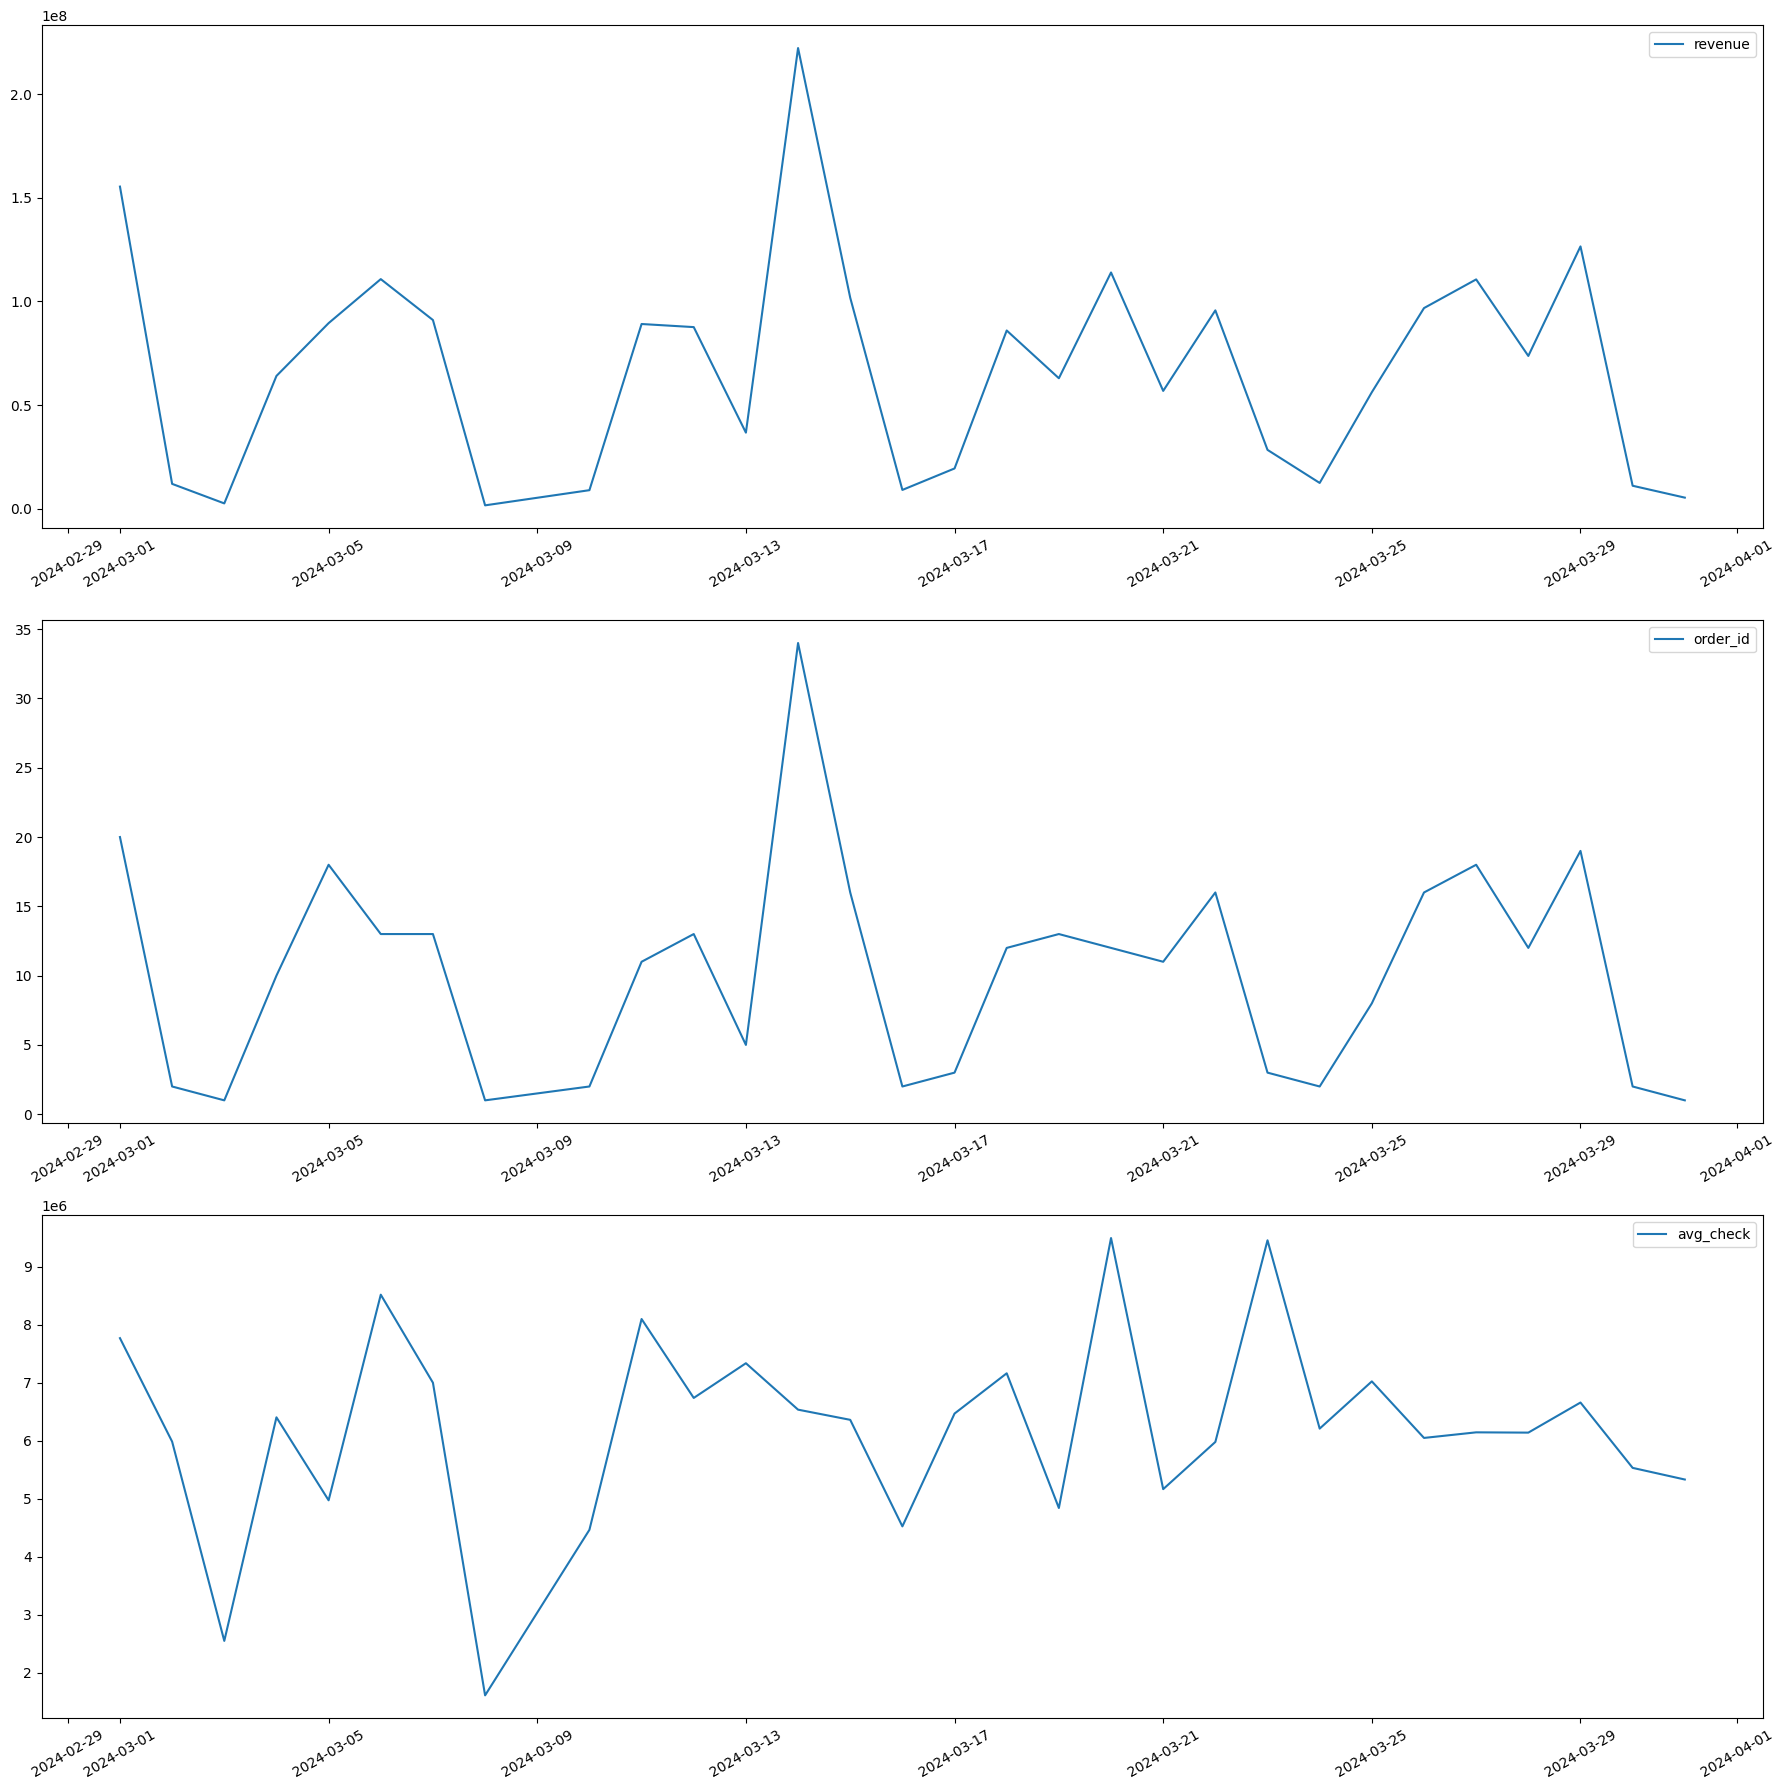

In [32]:
metrics = ['revenue', 'order_id', 'avg_check']

fig, axes = plt.subplots(3, 1, figsize=(18, 18))

for i, mertic in enumerate(metrics):
    df = df_report_by[['date', mertic]].set_index('date')
    sns.lineplot(data=df, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].set_xlabel('')
plt.tight_layout()

- число заказов и выручка не каждый день изменяются в одинаковом направлении, если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла.

- средний чек и выручка не каждый день изменяются в одинаковом направлении, если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла.

- в день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение

- с течением времени выручка то увеличивается, то уменьшается

- на протяжении всего месяца средний чек то увеличивается, то уменьшается

### Проанализируем интерес клиентов к брендам

Какие бренды востребованы среди клиентов, а какие — нет. **Посчитаем, сколькими брендами интересовались клиенты**

In [33]:
df_full.head()
df_full['brand'] = df_full.name.apply(lambda x: x.split(',')[0])
df_full.brand.nunique()

121

Посчитаем, какую выручку принес каждый бренд и в скольких подтвержденных заказах были товары этого бренда. **Определите, какой бренд принес наибольшую выручку.**

In [34]:
df_full.groupby(['brand', 'status'], as_index=False).agg({'revenue':'sum', 'order_id':'nunique'})\
    .sort_values('revenue', ascending=False)


,brand,status,revenue,order_id
78,JBL,confirmed,2.665961e+08,264
73,Heco,confirmed,2.388163e+08,229
90,Klipsch,confirmed,2.039024e+08,205
194,Yamaha,confirmed,1.658651e+08,218
83,KEF,confirmed,1.465101e+08,73
...,...,...,...,...
34,Bravo Audio,confirmed,2.405086e+04,1
118,Nobsound,canceled,2.245813e+04,1
2,ART,canceled,1.511546e+04,1
185,Victrola,canceled,1.241355e+04,1


**Нам нужно определить, какие бренды редко попадают в заказы, хотя товаров таких брендов на самом деле много.**
Начнем с того, что определим, какие товары из имеющихся в продаже хоть раз заказывали, а какие — нет.

In [38]:
products_in_orders = df_confirmed.product_id.unique()
df_products['is_in_orders'] = df_products.id.apply(lambda x: 'yes' if x in products_in_orders else 'no')
df_products.is_in_orders.value_counts()

is_in_orders
yes    1180
no      497
Name: count, dtype: int64

Посмотрим на эти данные в разрезе по брендам. **Определим, у каких брендов доля ни разу не заказанных товаров была больше половины от всех продаваемых товаров этого бренда.** Но не берем в расчет бренды, которые представлены маленьким числом товаров меньше 15, они не захламляют виртуальную «полку».

In [145]:
df_products['brand'] = df_products.name.apply(lambda x: x.split(',')[0])
brands_no_orders_pivot = df_products.groupby(['brand', 'is_in_orders'], as_index=False).agg({'id':'nunique'})\
    .rename(columns={'id':'products'})\
    .pivot(columns='is_in_orders', index='brand', values='products').fillna(0).reset_index()
brands_no_orders_pivot['total'] = brands_no_orders_pivot.no + brands_no_orders_pivot.yes
brands_no_orders_pivot['no_ratio'] = brands_no_orders_pivot.no / brands_no_orders_pivot.total
brands_no_orders_pivot.query('total > 15 and no_ratio > 0.5').brand.to_list()

['Dali', 'KEF', 'Marantz', 'Pioneer']

### Составим отчет по продажам менеджеров

Чтобы компания знала, кого из менеджеров отдела продаж премировать, а с кем провести беседу по итогам месяца, **попросили сделать отчет по сделкам каждого менеджера**: сколько он оформил подтвержденных заказов и какую выручку они принесли. **Поэтому посчитаем значения в процентах: какой % выручки от общей выручки за месяц приходится на каждого менеджера, и какой % заказов от общего числа заказов.**

In [39]:
manager_all = df_confirmed.groupby('manager', as_index=False).agg({'revenue':'sum', 'order_id':'nunique'})\
    .rename(columns={'order_id':'orders'}).sort_values('revenue', ascending=False)
manager_all['percente_sum'] = (manager_all.revenue / manager_all.revenue.sum()).mul(100).round(2)
manager_all['percente_orders'] = (manager_all.orders / manager_all.orders.sum()).mul(100).round(2)
manager_all

,manager,revenue,orders,percente_sum,percente_orders
9,Маргарита Камертонова,3.473886e+08,48,17.04,15.53
4,Виктор Тромбонов,3.188999e+08,50,15.65,16.18
8,Максим Барабанов,2.401478e+08,40,11.78,12.94
5,Владимир Ударников,2.084865e+08,31,10.23,10.03
0,Алексей Саксофонов,1.953435e+08,27,9.58,8.74
7,Ксения Балалайкина,1.817621e+08,27,8.92,8.74
6,Екатерина Тарелкина,1.781576e+08,28,8.74,9.06
10,Надежда Гармошкина,1.347836e+08,21,6.61,6.80
1,Анастасия Дудкина,1.234504e+08,20,6.06,6.47
2,Антон Скрипкин,5.150268e+07,7,2.53,2.27


<Axes: xlabel='revenue', ylabel='manager'>

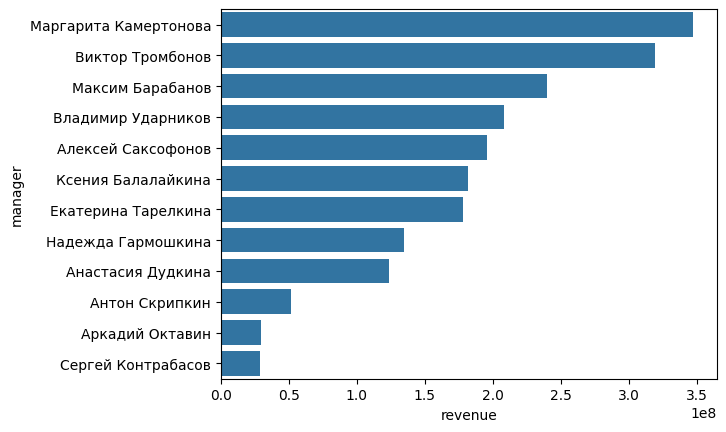

In [40]:
sns.barplot(data=manager_all, x='revenue', y='manager')

<Axes: xlabel='orders', ylabel='manager'>

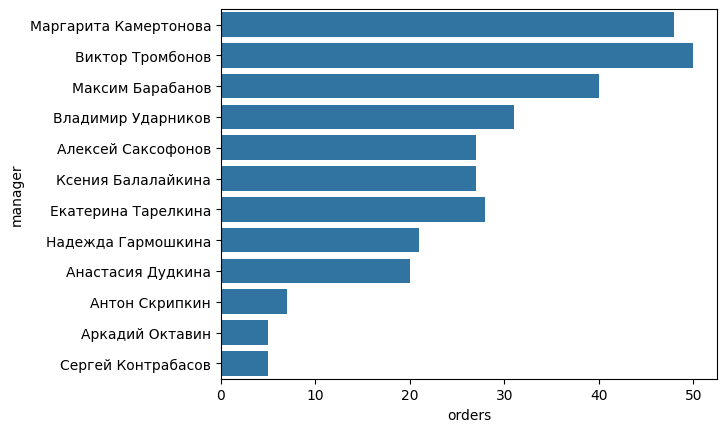

In [41]:
sns.barplot(data=manager_all, x='orders', y='manager')

- лучшим менеджером по % выручки стала Маргарита Камертонова
- в этом месяце нельзя выделить явную пятерку лидеров по % выручки, которые сильно оторвались от остальных
- лидер по % заказов реализовал более 16% заказов
- наихудшие показатели у Сергея Контрабасова


## Итоги

В ходе анализа продаж аудиотехники были выполнены следующие задачи:

1. Исследована динамика заказов, выявлены аномальные дни и их причины.
2. Посчитаны ключевые метрики месяца: общая выручка, средний чек, ежедневная динамика.
3. Определены наиболее популярные бренды среди клиентов, а также бренды с низкой вовлечённостью.
4. Проанализирована эффективность работы менеджеров. Выявлены лидеры по выручке.


В  проекте проанализировали продажи музыкальных товаров: собрали данные, посчитали ключевые метрики в динамике; определили дни, которые выбиваются из общей картины, и выяснили причину этого; нашли наиболее прибыльные бренды и те, которые зря занимают место на виртуальной «полке».